# Generates Mobility file for inference

In [2]:
%load_ext autoreload
%autoreload 2

import sys
if '..' not in sys.path:
    sys.path.append('..')
    
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import os

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

# from lib.settings.town_settings_kaiserslautern import *
# from lib.settings.town_settings_ruedesheim import *
# from lib.settings.town_settings_tirschenreuth import *
# from lib.settings.town_settings_tubingen import *
from lib.settings.town_settings_sanfrancisco import *

# from lib.settings.town_settings_lausanne import *
# from lib.settings.town_settings_locarno import *
# from lib.settings.town_settings_lucerne import *
# from lib.settings.town_settings_jura import *

# Downsampling factor of population and sites
downsample = 600

# Country for different age groups
country = 'US' # 'GER', 'CH'

# Set the population generation mode.
# 3 options available: custom | random | heuristic
population_by = 'custom'

# Downsample population 
population_per_age_group = np.round(
    population_per_age_group * (town_population / (downsample * region_population))).astype('int').tolist()

print(f'Population per age group: {population_per_age_group}')


model_essential=True
if model_essential == True:
    '''Hack: Must be changed if want to model essential workers not in SF'''
    from lib.settings.town_settings_sanfrancisco import _essential_prop_per_age_group, _essential_mobility

    essential_type = 3 # 0:edu, 1:social, 2:office, 3:supermarket
    essential_to_total_ratio = 0.2

    essential_distribution = np.array([
    0,      # 0-4
    0,      # 5-14
    0.0125,   # 15-19
    0.0682,   # 20-24
    0.4616,   # 25-44
    0.3889,   # 45-59
    0.0688,   # 60-79
    0])     # 80+

    num_essential_workers = np.floor(sum(population_per_age_group)*essential_to_total_ratio).astype('int').tolist()
    num_essential_per_age_group = np.floor(num_essential_workers * essential_distribution).astype('int').tolist()
    essential_prop_per_age_group = np.divide((num_essential_per_age_group),(population_per_age_group))
    
    strFormat = len(essential_prop_per_age_group) * '{:.2%} '
    print(f'Proportion of age groups that are essential workers:\n {strFormat.format(*essential_prop_per_age_group)}')
    print(f'Essential workers per age group:\n {num_essential_per_age_group}')
else:
    essential_prop_per_age_group = None
    
    
# This block sends queries to OpenStreetMap
# Make sure you have a working internet connection
# If an error occurs during execution, try executing again 
# If the call times out or doesn't finish, try restarting your internet connection by e.g. restarting your computer
site_files=[]
for root,dirs,files in os.walk(sites_path):
    for f in files:
        if f.endswith(".txt") and f != 'buildings.txt':
            site_files.append(sites_path+f)

site_loc, site_type, site_dict, density_site_loc = generate_sites(bbox=bbox, query_files=site_files,sites_path=sites_path,
                                site_based_density_file=sites_path+'buildings.txt')

# before downsampling
print(site_dict)
print('before downsampling Number of sites: ',np.sum(np.array(site_type)==0),
                          np.sum(np.array(site_type)==1),
                          np.sum(np.array(site_type)==2),
                          np.sum(np.array(site_type)==3))

# site_downsample = downsample
site_downsample = 200

if site_downsample > 1:

    # Zihan: new downsampling method so that each type is downsampled by the same value
    site_loc_downsampled = []
    site_type_downsampled = []
    for i in range(len(site_dict)):
        curr_type_all = np.zeros(len(site_type))
        curr_type_all[np.array(site_type)==i] = 1
        idx = np.random.choice(len(site_type), size=int(np.sum(np.array(site_type)==i) / site_downsample), 
                               replace=False, p=curr_type_all / np.sum(np.array(site_type)==i))
        site_loc_downsampled = site_loc_downsampled + np.array(site_loc)[idx].tolist()
        site_type_downsampled = site_type_downsampled + np.array(site_type)[idx].tolist()
    site_loc = site_loc_downsampled
    site_type = site_type_downsampled

print('after downsample Number of sites: ',np.sum(np.array(site_type)==0),
                          np.sum(np.array(site_type)==1),
                          np.sum(np.array(site_type)==2),
                          np.sum(np.array(site_type)==3))


if region_population == town_population:
    tile_level = 15
else:
    tile_level = 16

if population_by == 'custom':
    # generate population across tiles based on density input
    print('Tile level: ', tile_level)
    home_loc, people_age, home_tile, tile_loc, people_household, essential_workers, num_essential_workers, essential_work_site, is_traced, is_traced_infectious = generate_population(
            density_file=population_path, bbox=bbox,
            population_per_age_group=population_per_age_group, 
            household_info=household_info, tile_level=tile_level, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group,
            site_type = site_type, essential_type = essential_type)
    
elif population_by == 'random':
    # generate population across tiles uniformly at random
    home_loc, people_age, home_tile, tile_loc, people_household , essential_workers, num_essential_workers, essential_work_site, is_traced, is_traced_infectious = generate_population(
            bbox=bbox, population_per_age_group=population_per_age_group,
            tile_level=16, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group)
    
elif population_by == 'heuristic':
    # generate population across tiles proportional to buildings per tile
    home_loc, people_age, home_tile, tile_loc, people_household , essential_workers, num_essential_workers, essential_work_site, is_traced, is_traced_infectious = generate_population(
            bbox=bbox, density_site_loc=density_site_loc,
            population_per_age_group=population_per_age_group, tile_level=16, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group)

essential_to_total_pop_ratio = num_essential_workers/sum(population_per_age_group)   
print(f'Num essential workers: {np.array(essential_workers).sum()}')


tile_site_dist = compute_distances(site_loc, tile_loc)


# e.g. line 0 corresponds to age 0-4 in Germany
# a lot of eduction (kindergarden), some social, no public transport, no office, no supermarket
# the age groups are chosen to match the age groups used in case data by national authorities
# GERMANY
if country == 'GER':
    mob_rate_per_age_per_type = [
        [5, 1, 0, 0, 0], # 0-4
        [5, 2, 3, 0, 0], # 5-14
        [2, 2, 3, 3, 1], # 15-34
        [0, 2, 1, 5, 1], # 35-59
        [0, 3, 2, 0, 1], # 60-79
        [0, 2, 1, 0, 1]]  # 80+
    dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
    variety_per_type = [1, 10, 5, 1, 2]

# SWITZERLAND
elif country == 'CH':
    mob_rate_per_age_per_type = [
       [5, 1, 0, 0, 0], # 0-9
       [5, 2, 3, 0, 0], # 10-19
       [2, 2, 3, 3, 1], # 20-29
       [2, 2, 3, 3, 1], # 30-39
       [0, 2, 1, 5, 1], # 40-49
       [0, 2, 1, 5, 1], # 50-59
       [0, 3, 2, 0, 1], # 60-69
       [0, 3, 2, 0, 1], # 70-79
       [0, 2, 1, 0, 1]] # 80+
    dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
    variety_per_type = [1, 10, 5, 1, 2]
    
elif country == 'US':
    #  {0: 'education', 1: 'office', 2: 'social', 3: 'supermarket'}
    mob_rate_per_age_per_type = [
         [5,    0,    0,   0],    # 0-5
         [5,    0,    0,   0],    # 5-14
         [5,    0,    3.6, 0.22], # 15-19
         [1.48, 3.52, 3.6, 0.21], # 20-24
         [0,    5,    3.6, 0.27], # 25-44
         [0,    5,    3.6, 0.36], # 45-59
         [0,    0,    3.6, 0.35], # 60-79
         [0,    0,    3.6, 0.35]] # 80+

    dur_mean_per_type = [5.0, 5.0, 0.64, 0.4]
    variety_per_type = [1, 1, 10, 2]
    
    if model_essential==True:
        if essential_type == 0:
            essential_mob_rate_per_type = [5, 0, 3.6, 0.27]
            essential_dur_mean_per_type = [5, 0, 0.64, 0.4]
        elif essential_type == 1:
            essential_mob_rate_per_type = [0, 5, 3.6, 0.27]
            essential_dur_mean_per_type = [0, 5, 0.64, 0.4]
        elif essential_type == 2:
            essential_mob_rate_per_type = [0, 0, 5, 0.27]
            essential_dur_mean_per_type = [0, 0, 5, 0.4]
        elif essential_type == 3:
            essential_mob_rate_per_type = [0, 0, 3.6,  5]
            essential_dur_mean_per_type = [0, 0, 0.64, 5]
    
        essential_mob_rate_per_type = np.divide(np.array(essential_mob_rate_per_type), (24.0 * 7))

    else:
        essential_mob_rate_per_type, essential_dur_mean_per_type, essential_variety_per_type = None, None, None
else:
    raise ValueError('Invalid country code.')
    
# convert to average visits per hour per week, to be compatible with simulator
mob_rate_per_age_per_type = np.divide(np.array(mob_rate_per_age_per_type), (24.0 * 7))

# time horizon
delta  = 4.6438 # as set by distributions

print('Population (by Age): ', population_per_age_group)
print('Sites (by type):     ',  [(np.array(site_type) == i).sum() for i in range(len(mob_rate_per_age_per_type[0]))])
print('Total:', sum(population_per_age_group), len(site_type))


kwargs = dict(
    home_loc=home_loc, 
    people_age=people_age, 
    site_loc=site_loc, 
    num_people_unscaled=town_population,
    region_population=region_population,
    site_type=site_type, 
    site_dict=site_dict, 
    downsample=downsample,
    mob_rate_per_age_per_type=mob_rate_per_age_per_type,
    daily_tests_unscaled=daily_tests_unscaled, 
    dur_mean_per_type=dur_mean_per_type, 
    variety_per_type=variety_per_type, 
    delta=delta,
    home_tile=home_tile, 
    tile_site_dist=tile_site_dist, 
    people_household=people_household,
    essential_workers=essential_workers,
    essential_mob_rate_per_type=essential_mob_rate_per_type,
    essential_dur_mean_per_type = essential_dur_mean_per_type,
    essential_work_site = essential_work_site,
    essential_type=essential_type,
    is_traced = is_traced, 
    is_traced_infectious = is_traced_infectious)


if model_essential==False:
    outfile = f'lib/mobility/{town_name}_settings_{downsample}.pk'
else:
    outfile = f'lib/mobility/{town_name}_settings_ds{downsample}_type{essential_type}_prop{essential_to_total_ratio}.pk'
with open(outfile, 'wb') as fp:
    pickle.dump(kwargs, fp)
print(f'Saved mobility settings to {outfile}')

mob = MobilitySimulator(**kwargs)
    
num_essen = 0
num_non_essen = 0
work_site = []
for i in range(mob.num_people):
    if mob.essential_workers[i]:
        num_essen += 1
        work_site_temp = mob.essential_work_site[i]
        if work_site_temp not in work_site:
            if work_site_temp > -1 :
                work_site.append(work_site_temp)
            #print('essential worker no:',i,' working at site:',mob.essential_work_site[i])
    else:
        num_non_essen += 1

num_workers_at_work_site = [0]*len(work_site)
for i in range(mob.num_people):
    for j in range(len(work_site)):
        if mob.essential_work_site[i] == work_site[j]:
            num_workers_at_work_site[j] += 1
    
print('total population:',mob.num_people,', sites:', len(site_type))
print('essential:',num_essen,', non_essential:',num_non_essen,', propotion:',num_essen/mob.num_people)
print('essential proortion per age group:',essential_prop_per_age_group)
print('Population (by Age): ', population_per_age_group,np.array(population_per_age_group).sum())
print('Sites by type: ',  [(np.array(site_type) == i).sum() for i in range(len(dur_mean_per_type))])
print('essential type:',essential_type)
print('work_site:',work_site,len(work_site))
print('number of workers at work site:',num_workers_at_work_site, np.array(num_workers_at_work_site).sum())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Population per age group: [65, 99, 51, 88, 549, 278, 227, 60]
Proportion of age groups that are essential workers:
 0.00% 0.00% 5.88% 21.59% 23.68% 39.57% 8.37% 0.00% 
Essential workers per age group:
 [0, 0, 3, 19, 130, 110, 19, 0]
Query 1 OK.
Query 2 OK.
Query 3 OK.
Query 4 OK.
Query 5 OK.
{0: 'education', 1: 'office', 2: 'social', 3: 'supermarket'}
before downsampling Number of sites:  371 4944 3160 381
after downsample Number of sites:  1 24 15 1
Tile level:  15
Num essential workers: 251
Population (by Age):  [65, 99, 51, 88, 549, 278, 227, 60]
Sites (by type):      [1, 24, 15, 1]
Total: 1417 41
Saved mobility settings to lib/mobility/San_Francisco_settings_ds600_type3_prop0.2.pk
total population: 1418 , sites: 41
essential: 251 , non_essential: 1167 , propotion: 0.1770098730606488
essential proortion per age group: [0.         0.         0.05882353 0.21590909 0.23679417 0.39568345
 0.08370044 

In [14]:
print(dir(mob))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_contacts', '_find_mob_trace_overlaps', '_group_mob_traces', '_simulate_mobility', 'daily_tests_unscaled', 'delta', 'downsample', 'dur_mean_per_type', 'essential_dur_mean_per_type', 'essential_mob_rate_per_type', 'essential_type', 'essential_work_site', 'essential_workers', 'find_contacts_of_indiv', 'from_pickle', 'home_loc', 'home_tile', 'households', 'is_in_contact', 'is_traced', 'is_traced_infectious', 'list_intervals_in_window_individual_at_site', 'mob_rate_per_age_per_type', 'mode', 'next_contact', 'num_age_groups', 'num_people', 'num_people_unscaled', 'num_site_types', 'num_sites', 'people_age', 'people_household', 'region_population',

Text(0, 0.5, 'Number of Households')

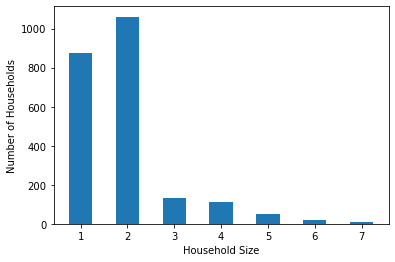

In [11]:
unique_household, counts_household = np.unique(people_household, return_counts=True)
plt.hist(counts_household,bins=range(1,9),align='left',rwidth=0.5)
plt.xlabel('Household Size')
plt.ylabel('Number of Households')

In [21]:
mob = MobilitySimulator(**kwargs)
mob.verbose = True

In [22]:
max_time = 17 * 24.0 # e.g. 17 days
%time mob.simulate(max_time=max_time, seed=12345)
# %time mob.to_pickle(f'tu_mobility_{downsample_population}_{downsample_sites}.pk')

Simulate mobility for 408.00 time units... Simulated 112576 visits.
Find contacts... 
CPU times: user 44 s, sys: 585 ms, total: 44.6 s
Wall time: 44.6 s


# Laura Experiments

In [71]:
# def _num_interactions(contact_list):
#     interactions = 0
#     for contact in contact_list:
#         interactions += 

def num_contacts_and_interactions(mob):
    num_contacts = np.array([len(mob.contacts[i]) for i in mob.contacts])
    num_interactions = np.array([sum([len(mob.contacts[i][j]) for j in mob.contacts[i]]) for i in mob.contacts])
    return num_contacts, num_interactions

num_contacts, num_interactions = num_contacts_and_interactions(mob)
print(num_contacts, num_interactions)
print(np.unique(num_interactions))

[329 396 278 ... 276 219 217] [381 536 284 ... 334 221 257]
[  31   38   39 ... 3219 3263 3277]


In [55]:
len(np.unique(list(mob.contacts[3].keys())))

263

In [56]:
len(mob.contacts[3].keys())

263

In [62]:
mob.contacts[3]

defaultdict(interlap.InterLap,
            {618: <interlap.InterLap at 0x7fe815e3acd0>,
             683: <interlap.InterLap at 0x7fe815e4c910>,
             841: <interlap.InterLap at 0x7fe815e9e050>,
             888: <interlap.InterLap at 0x7fe815eb8e90>,
             1724: <interlap.InterLap at 0x7fe816124d50>,
             1760: <interlap.InterLap at 0x7fe816166510>,
             1834: <interlap.InterLap at 0x7fe8161a5150>,
             1882: <interlap.InterLap at 0x7fe8161da290>,
             2563: <interlap.InterLap at 0x7fe8163f6bd0>,
             2723: <interlap.InterLap at 0x7fe8164bfc90>,
             2740: <interlap.InterLap at 0x7fe8164da0d0>,
             2790: <interlap.InterLap at 0x7fe81651ab10>,
             2888: <interlap.InterLap at 0x7fe8165b6a90>,
             2933: <interlap.InterLap at 0x7fe8165c7f50>,
             3663: <interlap.InterLap at 0x7fe816765450>,
             3951: <interlap.InterLap at 0x7fe8168dcb90>,
             4353: <interlap.InterLap at 0x7f

In [67]:
import pdb
# len(mob.contacts[3][841])
for person_i in mob.contacts:
    i_contacts = mob.contacts[person_i]
    for person_j in i_contacts:
        inter = i_contacts[person_j]
        if len(inter)>1:
            pdb.set_trace()
            

> <ipython-input-67-043a0dc2911a>(5)<module>()
      3 for person_i in mob.contacts:
      4     i_contacts = mob.contacts[person_i]
----> 5     for person_j in i_contacts:
      6         inter = i_contacts[person_j]
      7         if len(inter)>1:

ipdb> len(inter)
2
ipdb> inter
ipdb> inter[0]
*** TypeError: 'InterLap' object is not subscriptable
ipdb> inter._iset
[Contact(t_from=181.40921495309013, t_to=181.71071169279372, indiv_i=0, indiv_j=4095, site=7, duration=0.3014967397035946, id_tup=(6, 7)), Contact(t_from=343.4363672678988, t_to=343.6778991244138, indiv_i=0, indiv_j=4095, site=86, duration=0.24153185651499598, id_tup=(12, 15))]
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> <ipython-input-67-043a0dc2911a>(5)<module>()
      3 for person_i in mob.contacts:
      4     i_contacts = mob.contacts[person_i]
----> 5     for person_j in i_contacts:
      6         inter = i_contacts[person_j]
      7         if len(inter)>1:

ipdb> q


BdbQuit: 

In [65]:
def household_size(mob):
    people_household = mob.people_household
    unique_household, counts_household = np.unique(people_household, return_counts=True)
    f = lambda x: counts_household[x]
    household_size = f(people_household)
    return household_size
    # plt.hist(household_size,bins=range(1,9),align='left',rwidth=0.5)
    # plt.xlabel('Household Size')
    # plt.ylabel('Number of Households')

In [36]:
len(household_size)

8499